In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Dataset related functions ###

def all_same_length(*args):
    return all(len(a) == len(args[0]) for a in args)

def shuffle_together(*numpy_arrays):
    assert all_same_length(*numpy_arrays)
    permut = np.random.permutation(len(numpy_arrays[0]))
    return tuple(a[permut] for a in numpy_arrays)

def get_inner_slice_from_k_split(k, ith_slice, numpy_array):
    """The validation part of the data"""
    split_length = len(numpy_array) // k 
    return numpy_array[ith_slice * split_length : (ith_slice + 1) * split_length]
    
def get_outer_slice_from_k_split(k, ith_slice, numpy_array):
    """The training part of the data"""
    split_length = len(numpy_array) // k 
    return np.concatenate((
        numpy_array[:ith_slice * split_length],
        numpy_array[(ith_slice + 1) * split_length:]),
        axis=0)

def get_k_fold_sets(k, ith_set, x_data, y_targets):
    
    x_train = get_outer_slice_from_k_split(k, ith_set, x_data)
    y_train = get_outer_slice_from_k_split(k, ith_set, y_targets)
    
    x_valid = get_inner_slice_from_k_split(k, ith_set, x_data)
    y_valid = get_inner_slice_from_k_split(k, ith_set, y_targets)
    
    return (x_train, y_train), (x_valid, y_valid)

In [3]:
### Model related functions ###

def make_model(neurons, activations, input_shape, verbose=True,
               optimizer='sgd', loss='categorical_crossentropy', metrics=['acc']):
    model = keras.models.Sequential()
    zzz = zip(neurons, activations)
    
    n, a = next(zzz)
    model.add(keras.layers.Dense(n, input_shape=input_shape, activation=a))
    for n, a in zzz:
        model.add(keras.layers.Dense(n, activation=a))
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], 'bo', label="Training " + key)
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], 'r+', label='Validation ' + key)
        plt.legend()
        
    plt.show()

In [4]:
### Some other utilities ###

def average_histories(histories, for_keys=None):
    if for_keys == None:
        for_keys = histories[0].keys()
        
    average_history = {}
    for key in for_keys:
        average_history[key] = [
            np.mean([hist[key][epoch] for hist in histories]) for epoch in range(len(histories[0][key]))]
        
    return average_history

def kfoldize(K, train_data, train_targets, epochs, batch_size, model_factory, verbose_level=1):
    histories = []
    for i in range(K):
        if verbose_level:
            print('fold', i+1, 'out of', K)
        kfold_training, kfold_validation = get_k_fold_sets(K, i, train_data, train_targets)
        model = model_factory()
        hist = model.fit(*kfold_training, validation_data=kfold_validation,
                        epochs=epochs, batch_size=batch_size, verbose=(verbose_level >= 10))
        histories.append(hist.history)
        
    return histories

In [5]:
### Load the dataset, normalize ###

from keras.datasets import boston_housing

(orig_x_train, orig_y_train), (x_test, y_test) = boston_housing.load_data()

orig_x_train, orig_y_train = shuffle_together(orig_x_train, orig_y_train)

mean = np.mean(orig_x_train, axis=0)
std = np.std(orig_x_train, axis=0)

orig_x_train -= mean
orig_x_train /= (2 * std)

x_test -= mean
x_test /= (2 * std)

WANTED_METRICS = {'val_mean_absolute_error', 'val_mean_squared_error', 'mean_absolute_error', 'mean_squared_error'}
KFOLDIZE_KWARGS = dict(K=8, train_data=orig_x_train, train_targets=orig_y_train,
                      epochs=300, batch_size=32, verbose_level=0)

Starting with small models, then growing, trying to get an idea about their behaviour and the behaviour of different optimizers, showing here just some of the original:

        val_mean_squared_error:  21.90
            mean_squared_error:  15.71
       val_mean_absolute_error:   3.18
           mean_absolute_error:   2.35


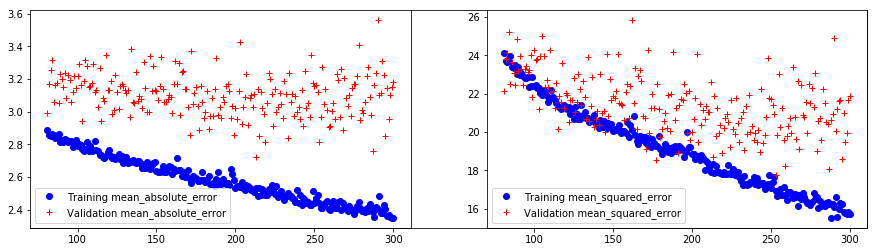

In [6]:
histories = kfoldize(**KFOLDIZE_KWARGS, 
                     model_factory=lambda: make_model(
                         (8, 4, 1),
                         ('selu','selu', 'linear'),
                         input_shape=(13,), verbose=False,
                         loss='mae', optimizer='sgd',
                         metrics=['mae', 'mse']))

avg_hist = average_histories(histories, WANTED_METRICS)
for k, v in avg_hist.items():
    print("{:>30}: {:6.2f}".format(k, v[-1]))
plot_history(avg_hist, start_x_from=80)

        val_mean_squared_error:  15.47
            mean_squared_error:  14.96
       val_mean_absolute_error:   2.57
           mean_absolute_error:   2.28


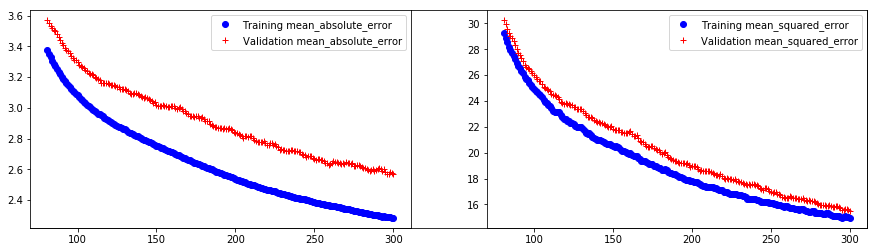

In [7]:
histories = kfoldize(**KFOLDIZE_KWARGS,
                     model_factory=lambda: make_model(
                         (8, 4,1),
                         ('relu','relu', 'linear'),
                         input_shape=(13,), verbose=False,
                         loss='mae', optimizer='adam',
                         metrics=['mae', 'mse']))

avg_hist = average_histories(histories, WANTED_METRICS)
for k, v in avg_hist.items():
    print("{:>30}: {:6.2f}".format(k, v[-1]))
plot_history(avg_hist, start_x_from=80)

In [8]:
for loss in ('mse', 'mae'):
    for optimizer in ('sgd', 'rmsprop', 'adam'):
        histories = kfoldize(K=8, verbose_level=0,
                             train_data=orig_x_train,
                             train_targets=orig_y_train,
                             epochs=100, batch_size=15,
                             model_factory=lambda: make_model(
                                 (13,1),
                                 ('elu', 'linear'),
                                 input_shape=(13,), verbose=False,
                                 loss=loss, optimizer=optimizer,
                                 metrics=['mae', 'mse']))

        avg_hist = average_histories(histories, ('val_mean_absolute_error', 'val_mean_squared_error'))
        for k, v in avg_hist.items():
            print("{}, {:>7}: {:>25}: {:6.2f}".format(loss, optimizer, k, v[-1]))
        print()

mse,     sgd:   val_mean_absolute_error:   2.69
mse,     sgd:    val_mean_squared_error:  12.65

mse, rmsprop:   val_mean_absolute_error:   3.10
mse, rmsprop:    val_mean_squared_error:  19.88

mse,    adam:   val_mean_absolute_error:   3.17
mse,    adam:    val_mean_squared_error:  22.73

mae,     sgd:   val_mean_absolute_error:   2.79
mae,     sgd:    val_mean_squared_error:  19.85

mae, rmsprop:   val_mean_absolute_error:   3.09
mae, rmsprop:    val_mean_squared_error:  24.93

mae,    adam:   val_mean_absolute_error:   2.97
mae,    adam:    val_mean_squared_error:  22.14



In [9]:
for loss in ('mse', 'mae'):
    for optimizer in ('sgd', 'rmsprop', 'adam'):
        histories = kfoldize(K=8, verbose_level=0,
                             train_data=orig_x_train,
                             train_targets=orig_y_train,
                             epochs=100, batch_size=15,
                             model_factory=lambda: make_model(
                                 (30,1),
                                 ('elu', 'linear'),
                                 input_shape=(13,), verbose=False,
                                 loss=loss, optimizer=optimizer,
                                 metrics=['mae', 'mse']))

        avg_hist = average_histories(histories, ('val_mean_absolute_error', 'val_mean_squared_error'))
        for k, v in avg_hist.items():
            print("{}, {:>7}: {:>25}: {:6.2f}".format(loss, optimizer, k, v[-1]))
        print()

mse,     sgd:   val_mean_absolute_error:   2.36
mse,     sgd:    val_mean_squared_error:  10.79

mse, rmsprop:   val_mean_absolute_error:   3.03
mse, rmsprop:    val_mean_squared_error:  18.54

mse,    adam:   val_mean_absolute_error:   3.14
mse,    adam:    val_mean_squared_error:  19.51

mae,     sgd:   val_mean_absolute_error:   2.83
mae,     sgd:    val_mean_squared_error:  19.90

mae, rmsprop:   val_mean_absolute_error:   2.81
mae, rmsprop:    val_mean_squared_error:  20.19

mae,    adam:   val_mean_absolute_error:   2.76
mae,    adam:    val_mean_squared_error:  19.44



In [10]:
for loss in ('mse', 'mae'):
    for optimizer in ('sgd', 'rmsprop', 'adam'):
        histories = kfoldize(K=8, verbose_level=0,
                             train_data=orig_x_train,
                             train_targets=orig_y_train,
                             epochs=100, batch_size=15,
                             model_factory=lambda: make_model(
                                 (13, 4, 1),
                                 ('relu', 'elu', 'linear'),
                                 input_shape=(13,), verbose=False,
                                 loss=loss, optimizer=optimizer,
                                 metrics=['mae', 'mse']))

        avg_hist = average_histories(histories, ('val_mean_absolute_error', 'val_mean_squared_error'))
        for k, v in avg_hist.items():
            print("{}, {:>7}: {:>25}: {:6.2f}".format(loss, optimizer, k, v[-1]))
        print()

mse,     sgd:   val_mean_absolute_error:    nan
mse,     sgd:    val_mean_squared_error:    nan

mse, rmsprop:   val_mean_absolute_error:   2.78
mse, rmsprop:    val_mean_squared_error:  15.85

mse,    adam:   val_mean_absolute_error:   2.71
mse,    adam:    val_mean_squared_error:  13.85

mae,     sgd:   val_mean_absolute_error:   2.45
mae,     sgd:    val_mean_squared_error:  16.05

mae, rmsprop:   val_mean_absolute_error:   3.78
mae, rmsprop:    val_mean_squared_error:  42.26

mae,    adam:   val_mean_absolute_error:   2.61
mae,    adam:    val_mean_squared_error:  16.77



In [11]:
for loss in ('mae', 'mse'):
    for optimizer in ('rmsprop','adam','sgd'):
        histories = kfoldize(K=8, verbose_level=0,
                             train_data=orig_x_train,
                             train_targets=orig_y_train,
                             epochs=100, batch_size=25,
                             model_factory=lambda: make_model(
                                 (30, 30,1),
                                 ('elu','elu', 'linear'),
                                 input_shape=(13,), verbose=False,
                                 loss=loss, optimizer=optimizer,
                                 metrics=['mae', 'mse']))

        avg_hist = average_histories(histories, ('val_mean_absolute_error', 'val_mean_squared_error'))
        for k, v in avg_hist.items():
            print("{}, {:>7}: {:>25}: {:6.2f}".format(loss, optimizer, k, v[-1]))
        print()

mae, rmsprop:   val_mean_absolute_error:   2.49
mae, rmsprop:    val_mean_squared_error:  16.80

mae,    adam:   val_mean_absolute_error:   2.48
mae,    adam:    val_mean_squared_error:  16.66

mae,     sgd:   val_mean_absolute_error:   2.58
mae,     sgd:    val_mean_squared_error:  17.27

mse, rmsprop:   val_mean_absolute_error:   2.64
mse, rmsprop:    val_mean_squared_error:  13.75

mse,    adam:   val_mean_absolute_error:   2.69
mse,    adam:    val_mean_squared_error:  14.43

mse,     sgd:   val_mean_absolute_error:   2.70
mse,     sgd:    val_mean_squared_error:  15.37



In [12]:
for loss in ('mse', 'mae'):
    for optimizer in ('sgd', 'rmsprop', 'adam'):
        histories = kfoldize(K=8, verbose_level=0,
                             train_data=orig_x_train,
                             train_targets=orig_y_train,
                             epochs=200, batch_size=15,
                             model_factory=lambda: make_model(
                                 (60, 40, 20, 1),
                                 ('elu', 'elu', 'elu', 'linear'),
                                 input_shape=(13,), verbose=False,
                                 loss=loss, optimizer=optimizer,
                                 metrics=['mae', 'mse']))

        avg_hist = average_histories(histories, ('val_mean_absolute_error', 'val_mean_squared_error'))
        for k, v in avg_hist.items():
            print("{}, {:>7}: {:>25}: {:6.2f}".format(loss, optimizer, k, v[-1]))
        print()

mse,     sgd:   val_mean_absolute_error:    nan
mse,     sgd:    val_mean_squared_error:    nan

mse, rmsprop:   val_mean_absolute_error:   2.29
mse, rmsprop:    val_mean_squared_error:  10.06

mse,    adam:   val_mean_absolute_error:   2.27
mse,    adam:    val_mean_squared_error:  10.13

mae,     sgd:   val_mean_absolute_error:   2.38
mae,     sgd:    val_mean_squared_error:  11.71

mae, rmsprop:   val_mean_absolute_error:   2.18
mae, rmsprop:    val_mean_squared_error:  10.86

mae,    adam:   val_mean_absolute_error:   2.22
mae,    adam:    val_mean_squared_error:  11.79



In [17]:
model = make_model((30, 30, 1),
                   ('elu','elu','linear'),
                   input_shape=(13,), verbose=False,
                   loss='mse', optimizer='adam', metrics=['mae'])

hist1 = model.fit(orig_x_train, orig_y_train,
                 epochs=1000, batch_size = 25, verbose=False)

model.evaluate(x_test, y_test)

102/102 [==============================] - 1s 15ms/step


[10.790202496098537, 2.2741290447758695]

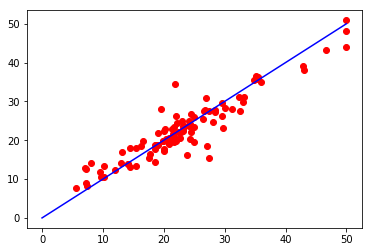

In [19]:
plt.plot(y_test, hist1.model.predict(x_test), 'ro')
plt.plot([0,50], [0,50], 'b')
plt.show()

In [21]:
print(np.sum(np.round(hist1.model.predict(x_test)[:,0]) == y_test) / len(y_test))
1/102

0.00980392156862745


In [18]:
model = make_model((60, 40, 20, 1),
                   ('elu','elu','elu','linear'),
                   input_shape=(13,), verbose=False,
                   loss='mse', optimizer='adam', metrics=['mae'])

hist2 = model.fit(orig_x_train, orig_y_train,
                 epochs=1000, batch_size = 25, verbose=False)

model.evaluate(x_test, y_test)

102/102 [==============================] - 2s 15ms/step


[11.359180076449524, 2.3761214181488635]

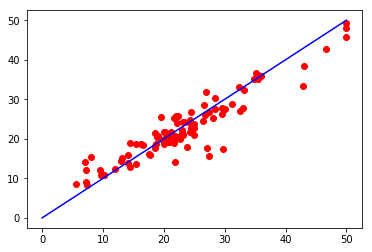

In [20]:
plt.plot(y_test, hist2.model.predict(x_test), 'ro')
plt.plot([0,50], [0,50], 'b')
plt.show()

In [23]:
print(np.sum(np.round(hist2.model.predict(x_test)[:,0]) == y_test) / len(y_test))
2/102

0.0196078431372549


0.0196078431372549

I after a lot of experimenting I found out that:
* SGD had surprisingly usually lowest MAE being trained on smaller networks, even though its progress is much noisier than that of Adam or RMSProp

* SGD had big troubles to finish training though - the metrics became NaN, this was especially happening with ReLU, using MSE as a loss function and having more than one hidden layer, it was a bit better using MAE and different activation functions

* Adam generally performed slightly better than RMSProp

* as expected k-fold validation for higher values of k was yielding more stable final metrics and trying to design the network without validation felt like blind-shooting

* one has to run the things many times to get the idea how it really is

* ELU seemed to be better then other *elu variants (at least over ReLU with some significance)


In the end I managed to train a model (the (30, 30, 1)) which performs relatively good - well, at least better than previously, now being just 1 wrong but on average being off by $2300.